In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

def predict_and_plot(csv_file):
    df = pd.read_csv(csv_file)
    df_grouped = df.groupby('Year')['Trade Value'].sum().reset_index()
    
    df_grouped['Date'] = pd.to_datetime(df_grouped['Year'].astype(str) + '-01-01')
    df_grouped.set_index('Date', inplace=True)
    df_grouped = df_grouped.asfreq('YS')
    
    adf_test = adfuller(df_grouped['Trade Value'].dropna())
    p_value = adf_test[1]
    print(p_value)
    
    # if p_value > 0.05:
    #     return "Data cannot be predicted
    train_end = pd.Timestamp('2021-01-01')
    train_data = df_grouped.loc[:train_end, 'Trade Value']
    
    model = ARIMA(train_data, order=(1,1,1))
    model_fit = model.fit()
    
    forecast_steps = len(df_grouped.loc['2022-01-01':])
    forecast = model_fit.forecast(steps=forecast_steps)
    forecast.index = df_grouped.loc['2022-01-01':].index
    
    raw_dates = df_grouped.index
    raw_values = df_grouped['Trade Value']
    pred_dates = forecast.index
    pred_values = forecast
    
    return raw_dates, raw_values, pred_dates, pred_values


0.5875310983257882


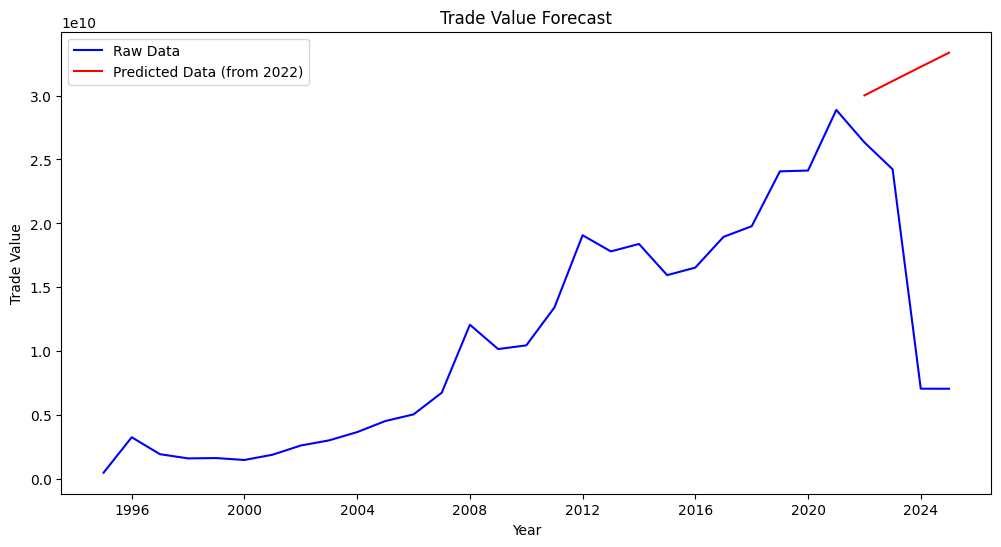

In [57]:
result = predict_and_plot('/Users/sandra/Desktop/UCU/hakathon/agriculture-losses/algorithm/agricultural_exports_combined.csv')

if isinstance(result, str):
    print(result)  # If "Data cannot be predicted"
else:
    raw_dates, raw_values, pred_dates, pred_values = result
    
    plt.figure(figsize=(12,6))
    plt.plot(raw_dates, raw_values, label='Raw Data', color='blue')
    plt.plot(pred_dates, pred_values, label='Predicted Data (from 2022)', color='red')
    plt.legend()
    plt.title('Trade Value Forecast')
    plt.xlabel('Year')
    plt.ylabel('Trade Value')
    plt.show()


0.5875310983257882


/var/folders/3q/g1gfc7_n2qs5_4k0w8zm6g280000gn/T/ipykernel_18971/663849182.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  connect_values = [raw_values[raw_dates <= '2021-01-01'][-1], pred_values.iloc[0]]


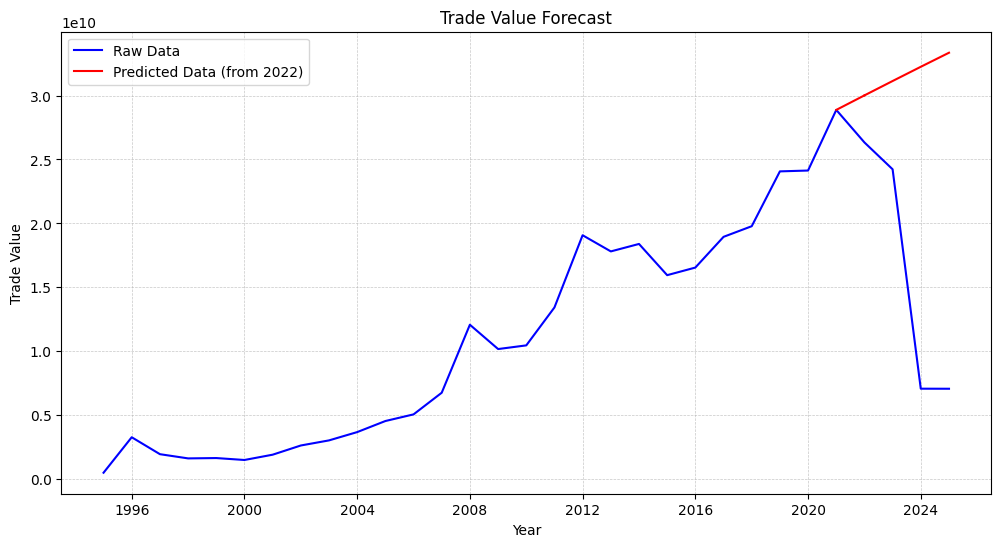

In [58]:
result = predict_and_plot('/Users/sandra/Desktop/UCU/hakathon/agriculture-losses/algorithm/agricultural_exports_combined.csv')

if isinstance(result, str):
    print(result)  # If "Data cannot be predicted"
else:
    raw_dates, raw_values, pred_dates, pred_values = result
    
    plt.figure(figsize=(12,6))
    
    # Plot full raw data (up to 2021)
    plt.plot(raw_dates, raw_values, label='Raw Data', color='blue')
    
    # Connect last raw point to first prediction point
    connect_dates = [raw_dates[raw_dates <= '2021-01-01'][-1], pred_dates[0]]
    connect_values = [raw_values[raw_dates <= '2021-01-01'][-1], pred_values.iloc[0]]
    plt.plot(connect_dates, connect_values, color='red')
    
    # Plot predictions starting from 2022
    plt.plot(pred_dates, pred_values, label='Predicted Data (from 2022)', color='red')
    
    # Add nice background grid
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.gca().set_axisbelow(True)  # Grid stays behind lines
    
    plt.legend()
    plt.title('Trade Value Forecast')
    plt.xlabel('Year')
    plt.ylabel('Trade Value')
    plt.show()


In [ ]:
def calculate_dcf_and_report(raw_dates, raw_values, pred_dates, pred_values, discount_rate=0.1):
    """
    discount_rate should be given as decimal, e.g., 10% -> 0.10
    """
    report = ""

    # Calculate DCF for each forecasted year
    dcf_values = []
    base_year = 2021  # Forecast starts from 2022

    for date, value in zip(pred_dates, pred_values):
        year = date.year
        t = year - base_year
        dcf = value / (1 + discount_rate) ** t
        dcf_values.append((year, value, dcf))
    
    total_npv = sum([x[2] for x in dcf_values])
    
    report += "==== Discounted Cash Flow (DCF) Report ====\n"
    report += f"Discount rate: {discount_rate*100:.2f}%\n"
    report += "\nYear | Forecasted Value | Discounted Cash Flow\n"
    report += "-"*45 + "\n"
    
    for year, forecasted, dcf in dcf_values:
        report += f"{year} | {forecasted:,.2f} | {dcf:,.2f}\n"
    
    report += "-"*45 + "\n"
    report += f"Total Net Present Value (NPV): {total_npv:,.2f}\n"
    report += "===========================================\n"

    return report


In [60]:
# result = predict_and_plot('your_csv_file.csv')

if isinstance(result, str):
    print(result)
else:
    raw_dates, raw_values, pred_dates, pred_values = result

    dcf_report = calculate_dcf_and_report(raw_dates, raw_values, pred_dates, pred_values, discount_rate=0.1)
    print(dcf_report)


==== Discounted Cash Flow (DCF) Report ====
Discount rate: 10.00%

Year | Forecasted Value | Discounted Cash Flow
---------------------------------------------
2022 | 30,017,202,670.64 | 27,288,366,064.22
2023 | 31,141,486,822.97 | 25,736,765,969.39
2024 | 32,254,236,746.24 | 24,233,085,459.23
2025 | 33,355,570,772.14 | 22,782,303,648.75
---------------------------------------------
Total Net Present Value (NPV): 100,040,521,141.60

